ionize Tutorial
===============

**ionize** is a Python module for calculating the properties of ions in aqueous solution. 

To load the library, simply import **ionize**.

In [1]:
from __future__ import print_function, absolute_import, division
import ionize

# We'll also import numpy to set up some of our inputs. 
# And pprint to prettily print some lists.
import numpy
import pprint

# And set up inline plotting.
from matplotlib.pyplot import *
%matplotlib inline

# Prettify numpy printing
numpy.set_printoptions(precision=3)

Ion
----
The basic building block of an **ionize** simulation is an ionic species, modeled by the **Ion** class. Call **ionize**.**Ion**(*name*, *z*, *pKa*, *absolute_mobility*). *name* is the name of the ion, typically as a string. *z* is a list containing the charge states of the ion. *pKa* is a list of the pKas of the charge states, with the same order as the list *z*. *absolute_mobility* is a list containing the absolute, infinite dilution mobilities of each charge state, ordered the same as the other two lists, in units of m<sup>2</sup>V<sup>-1</sup>s<sup>-1</sup>.

In [2]:
# Initialize an ion and print it. 
acid = ionize.Ion('myAcid', [-1], [5], [-25e-9])
base = ionize.Ion('myBase', [1], [8], [20e-9])
print(acid)        # The string includes only the class and name.
print(repr(base))  # The representation contains enough information to reconstruct the ion. 

Ion('myAcid')
Ion(alias=None, nightingale_data=None, reference_temperature=25.0, name='myBase', molecular_weight=None, valence=[1], reference_mobility=[2e-08], heat_capacity=None, reference_pKa=[8.0], enthalpy=None)


Once an ion species is initialized, you can call the properties of the ion, typically as a function of pH, ionic strength, and temperature, in that order. 

myAcid Ka at (I=0 M) = [  1.001e-05]
myAcid Ka at (I=0.5 M) = [  1.781e-05]


/home/lewis/Documents/github/ionize/ionize/Ion/mobility.py:43: UserWarning: Insufficient information for Onsager-Fuoss correction to mobility. Returning the Robinson-Stokes approximation.
  warnings.warn("Insufficient information for Onsager-Fuoss "


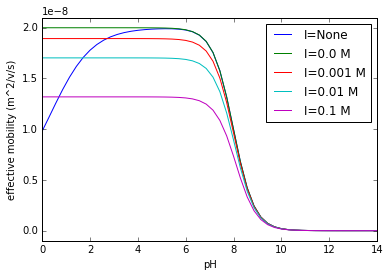

In [3]:
print('myAcid Ka at (I=0 M) =', acid.acidity())
print('myAcid Ka at (I=0.5 M) =', acid.acidity(ionic_strength=0.5))

pH = numpy.linspace(0,14)

for I in [None, 0., 0.001, 0.01, 0.1]:
    mu = [base.mobility(p, I) for p in pH]
    if I is not None:
        label = 'I={} M'.format(I)
    else:
        label = 'I=None'
    plot(pH, mu, label=label)

xlabel('pH'); xlim(0, 14)
ylabel('effective mobility (m^2/v/s)'); ylim(-.1e-8, 2.1e-8)
legend()
show()

Note the difference between ionic_strength parameters here. If ionic_strength is 0, the numerical value of 0 is used in each calculation. However, it is impossible to have a solution of pH 0 with ionic_strength of 0. 

When the default value of None is used for ionic_strength, ionize uses the minimum ionic strength at the selected pH. 

## Using the **ionize** database

Individually initializing ions is error-prone and time-consuming. To simplify the process, load ions from 
the database by initializing the database, and accessing the database like a dictionary. 

Ion(alias=None, nightingale_data=None, reference_temperature=25.0, name='histidine', molecular_weight=155.15, valence=[-1, 1, 2], reference_mobility=[-2.8300000000000002e-08, 2.8800000000000003e-08, 4.47e-08], heat_capacity=[-233.0, 176.0, 0.0], reference_pKa=[9.33, 6.04, 2.0], enthalpy=[43800.0, 29500.0, 3600.0])


/home/lewis/Documents/github/ionize/ionize/Ion/mobility.py:43: UserWarning: Insufficient information for Onsager-Fuoss correction to mobility. Returning the Robinson-Stokes approximation.
  warnings.warn("Insufficient information for Onsager-Fuoss "


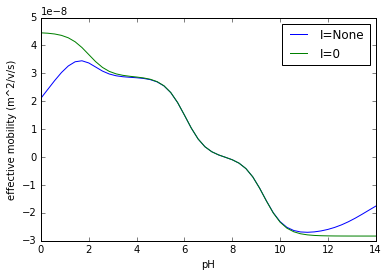

In [4]:
db = ionize.Database()
histidine = db['histidine']
print(repr(histidine))

for ionic_strength in (None, 0):
    mu_histidine = [histidine.mobility(p, ionic_strength=ionic_strength) for p in pH]
    plot(pH, mu_histidine, label="I={}".format(ionic_strength))
    
xlabel('pH'); xlim([0, 14])
ylabel('effective mobility (m^2/v/s)')
legend()
show()

### search_ion()

You can also search for ions in the database by name using **Database().search()**. Call it by specifying a *search_string*. **search()** will print the names of all ions that contain the *search_string*. **search** will not return a list of strings, so load the ion when you find what you want. 

In [5]:
print("Search results for 'amino'\n--------------------------")
pprint.pprint(db.search('amino'))
print("\nSearch results for 'chloric'\n----------------------------")
pprint.pprint(db.search('chloric'))
print("\nSearch results for 'per'\n------------------------")
pprint.pprint(db.search('per'))
print('\nOh, copper is what I was looking for.')
print(db.load('copper'))

Search results for 'amino'
--------------------------
('2-amino-2-methyl-1-propanol',
 'e-aminocaproic acid',
 'gamma-aminobutyric acid',
 'o-aminobenzoic acid',
 'p-aminobenzoic acid')

Search results for 'chloric'
----------------------------
('chloric acid', 'hydrochloric acid', 'perchloric acid')

Search results for 'per'
------------------------
('copper',
 'diperodone',
 'perchloric acid',
 'periodic acid',
 'permanganic acid',
 'peroxysulfuric acid',
 'perrhenic acid',
 'piperidine')

Oh, copper is what I was looking for.
Ion('copper')


### Other db functions
You can get the database data as a dictionary using the data method.

In [6]:
print(len(db.data), 'ions in database.')

522 ions in database.


Solution
--------
Getting the properties of a single ionic species in solution is useful, but the real challenge of dealing with aqueous solutions of ions is finding properties based on the equilibrium state of multiple ionic species. **ionize** can perform those calculations using the **Solution** class. **Solution** objects are initialized using **ionize**.**Solution**(*ions*, *concentrations*), where ions is a list of **Ion** objects and concentration is a list concentrations of the ions, with concentrations in molar.

In [7]:
hcl=database.load('hydrochloric acid')
tris=database.load('tris')
buffer=ionize.Solution([tris, hcl], [0.1, 0.085])

print 'pH =', buffer.pH
print 'I =', buffer.ionic_strength, 'M'
print 'conductivity =', buffer.conductivity(), 'S/m'
print 'buffering capacity =', buffer.buffering_capacity(), 'M'
print 'debye length =', buffer.debye(), 'm'

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-7-3ec72e740f06>, line 5)

**Solutions** can be initialized with ion names instead of ions. If so, the **Solution** calls **load_ion** to determine the ion identities.

In [ ]:
print [ion.name for ion in ionize.Solution(['bis-tris', 'acetic acid'], [0.1, 0.03]).ions]
print ionize.Solution(['bis-tris', 'acetic acid'], [0.1, 0.03]).concentration(database.load('acetic acid'))

We can iterate through solutions to quickly calculate the pH of a titration between two ions

In [ ]:
c_tris = 0.1
c_hcl = numpy.linspace(0.0, 0.2, 50)
t_pH = [ionize.Solution(['tris', 'hydrochloric acid'], [c_tris, c_h], temperature=25).pH for c_h in c_hcl]

plot(c_hcl/c_tris, t_pH)
xlabel('[HCl]/[Tris]')
ylabel('pH')
show()

A **Solution** can also be initialized without ions, e.g. as water. 

In [ ]:
water = ionize.Solution()
print 'I =', water.ionic_strength, 'M'
print 'pH =', water.pH
print 'conductivity =', water.conductivity(), 'S/m'

A **Solution** can also be added and multiplied through operator overloading. This can be useful when calculating the results of diltuions, as below. 

In [ ]:
print 'Stock:', buffer
dilution = 0.5 * buffer + 0.5 * water
print 'Dilution:', dilution

**Solutions** can be titrated to a specified pH. To do so, make a solution, and then specify a titrant, a property, and a target.  

In [ ]:
buff = ionize.Solution([tris], 0.1)

In [ ]:
print buff.titrate('hydrochloric acid', 8.2)
print buff.titrate('hydrochloric acid', 3)
print buff.conductivity()
print repr(buff.titrate('hydrochloric acid', 3, titration_property = 'conductivity'))
print repr(buff.titrate('hydrochloric acid', 8))


Temperature Effects
-------------------
Both **Ion** objects and **Solution** objects take T as an optional argument for temperature. Temperature should be specified in degrees C. 

**Ion** objects adjust their absolute mobility and pKa attributes based on temperature. They also make adjustments to their ionic strength correction algorithms based on temperature. The type of temperature adjustment data depends on the specific ion. For small ions, emperical data from literature is included. For organic molecules, &Delta;H and &Delta;Cp values may be provided. All ions also correct their mobilities for viscosity. 

In [ ]:
silver = database.load('silver')
tris = database.load('tris')
T = numpy.linspace(20.0, 80.0)
mu_silver = [silver.absolute_mobility(Tp) for Tp in T]
mu_tris = [tris.absolute_mobility(Tp) for Tp in T]
pKa_silver = [silver.pKa(0, Tp) for Tp in T]
pKa_tris = [tris.pKa(0, Tp) for Tp in T]

figure()
plot(T, mu_silver, label = 'Silver')
plot(T, mu_tris, label = 'Tris')
legend(loc = 'upper left')
xlabel('Temperature ($^{\circ}$C)'); ylabel('Absolute mobility ($m^2V^{-1}s^{-1}$)')
show()
figure()
plot(T, pKa_silver, label = 'Silver')
plot(T, pKa_tris, label = 'Tris')
legend(loc = 'lower left')
xlabel('Temperature ($^{\circ}$C)'); ylabel('pKa')
show()

**Solution** objects send their temperature correction parameters to the object that they contain. In addition, they use the temperature input to correct their ionic strength correction parameters. 

In [ ]:
buffer_ref = ionize.Solution(['tris', 'hydrochloric acid'], [.200, .100], temperature=25.)
mu_ref = buffer_ref.ions[1].mobility()
mup = []
pH = []
I = []
mu=[]
cond = []
for Tp in T:
    buffer = ionize.Solution([tris, hcl], [.200, .100], temperature=Tp)
    mu.append(buffer.ions[1].mobility())
    mup.append(buffer.ions[1].mobility()/mu_ref)
    pH.append(buffer.pH)
    I.append(buffer.ionic_strength)
    cond.append(buffer.conductivity())
#     mup.append(hcl.nightingale_function(Tp))
cond_norm = [c / cond[0] for c in cond]
figure()
plot(T, pH); xlabel('Temperature ($^{\circ}$C)'); ylabel('pH')
show()

figure()
plot(T, mup, label='chloride'); xlabel('Temperature ($^{\circ}$C)'); ylabel('$\mu$(T)/$\mu$(T$_o$)'); legend(loc='upper left')
show()

Conservation Functions
--------------------
Conservation functions are spatially invariant quantities that remain constant as a solution undergoes electrophoresis. They are useful in calculating ion concentrations in zones formed during electrophoresis. 

### The Kohlrausch Regulating Function (KRF)
The most basic conservation function is the KRF. This function is only valid for strongly ionized species, when water dissociation doesn't play a strong role. Solutions can calculate their own KRF values. They throw a warning if they contain species that are not strongly ionized.

In [ ]:
saltwater = ionize.Solution(['sodium', 'hydrochloric acid'], [0.1, 0.1])
print saltwater.kohlrausch()

In [ ]:
print buffer_ref.ions
print buffer_ref.kohlrausch()

### The Alberty Conservation Function

The Alberty conservation function is useful for weakly ionized monovalent species, when water dissocation doesn't play a strong role. 

In [ ]:
tcap = ionize.Solution(['tris', 'caproic acid'], [0.1, 0.05])
print tcap.alberty()


In [ ]:
tcit = ionize.Solution(['tris', 'citric acid'], [0.1, 0.05])
print tcit.alberty()

### The Jovin Conservation Function

The Jovin conservation function is applicable under the same conditions that the Alberty conservation function is. It is often used as a compliment.

In [ ]:
print tcap.jovin()

In [ ]:
print tcit.jovin()

### The Gas Conservation Functions

In [ ]:
print tcap.gas()
print tcit.gas()

### Serialization, Saving, and Loading
You can also save and load ions and solutions in JSON format.

In [ ]:
# %load_ext snakeviz

In [ ]:
# %%snakeviz
# database = ionize.Database()
# pH = np.linspace(0, 14)
# for ion in database:
#     for p in pH:
#         ion.mobility(p)

In [ ]:
database

In [ ]:
import itertools
concentrations = np.linspace(0, 0.14)
ref_mob = 50.e-9
z = [1, 2]
for zp, zm in itertools.product(z, repeat=2):
    positive_ion = ionize.Ion('positive', [zp], [14], [ref_mob])
    negative_ion = ionize.Ion('negative', [-zm], [0], [-ref_mob])
    mob = []
    i = []
    for c in concentrations:
        sol = ionize.Solution([positive_ion, negative_ion], [c/zp, c/zm])
        mob.append(sol.ions[0].actual_mobility() / ref_mob )
        i.append(sol.ionic_strength)
    plot(i, mob, label='-{}:{}'.format(zm, zp))
ylim(0, 1)
# xlim(0, .14)
legend(loc='lower left')
xlabel('Concentration (M)')
ylabel('$\mu$/$\mu_o$')
show()
        